In [ ]:
import os
import time
import numpy as np
import pandas as pd
from typing import Tuple
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 환경 코드

In [ ]:
class GridWorldEnvironment: # 환경 클래스 생성
    def __init__(self, start_point: Tuple, end_point: Tuple, gridworld_size:Tuple) :

        # 튜플로 좌표 넘겨 받기, 시작, 끝, 크기
        self.start_point=start_point
        self.end_point=end_point

        self.height, self.width =gridworld_size
        # action dictionary
        self.action_space =['up', 'down', 'left', 'right'] # 행동 스페이스, 상하좌우
        self.num_actions = len(self.action_space)
        self.actions={}
        dy=[-1,1,0,0]
        dx=[0,0,-1,1]
        for i in range(len(dy)) :
            self.actions[self.action_space[i]] = (dy[i], dx[i])

        self.present_state = start_point
        # 상태: 좌표, 에이전트가 움직인 좌표를 모두 담음
        self.traces=[]

            # # total states
            # self.total_states=[] # 모든 상태 좌표를 담음

            # for i in range(self.height):
            #     for j in range(self.width):
            #         self.total_states.append((i,j))

            # # 보상
            # # 처음은 0으로 초기화
            # self.reward = np.zeros(shpae=(self.height, self.width)).tolist()

        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

    # 그리기 함수
    def render(self) :

        # last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값 삭제

        for trace in traces :
            self.grid_world[trace[0]][trace[1]] = 'X'

        self.grid_world[self.start_point[0]][self.start_point[1]]='S'
        self.grid_world[self.end_point[0]][self.end_point[1]]= 'G'
        self.grid_world[self.present_state[0]][self.present_state[1]] = 'A'

        # string 으로 출력
        for i in range(self.height) :
            grid=""
            for j in range(self.width) :
                grid += self.grid_world[i][j]+' '
            print(grid)

    def reset(self) :
        self.present_state=self.start_point
        self.grid_world = np.full((self.height, self.width), fill_value=".").tolist()
        self.traces = []
        return self.start_point


    def step(self, action_idx:int) :
        action = self.action_space[action_idx]
        rm, cm = self.actions[action]
        next_state= (self.present_state[0]+rm, self.present_state[1]+cm)
        next_state = self.check_boundary(next_state)

        if next_state == self.end_point :
            reward = 100
            done=True
        else :
            reward = 0
            done = False

        self.present_state=next_state
        self.traces.append(self.present_state)

        return next_state, reward, done

    #3
    def check_boundary(self, state) :
        state = list(state) # 튜플은 수정할 수 없기 때문에 list
        for i in range(2) :
            if state[i] < 0 :
                state[i] = 0
            if i==0 and state[i] >= self.height :
                state[i] = self.height-1
            if i==1 and state[i] >= self.width :
                state[i] = self.width-1
        return tuple(state) # 다시 튜플로 return

        # #2
        # def state_after_action(self, state, action_idx:int) :
        #     action=self.action_space[action_idx] # up down ..
        #     rm, cm = self.actions[action]
        #     next_state = (state[0]+rm,state[1]+cm)
        #     return self.check_boundary(next_state)

        # #1
        # def get_reward (self, state, action_idx) :
        #     next_state = self.state_after_action(state, action_idx)
        #     return self.reward[next_state[0]][next_state[1]]

In [ ]:
g=GridWorldEnvironment(start_point = (0,0), end_point=(4,4), gridworld_size=(5,5))
print(g.actions)

{'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}


In [ ]:
class SARSAAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.num_actions=len(action_space)

        self.step_size=0.01
        self.discount_factor=0.9
        self.epsilon =1.0
        self.epsilon_decay=0.999
        self.epsilon_min =0.01

        self.q_table=defaultdict(lambda: np.zeros(self.num_actions).tolist())

    def update_q_table(self, state, action_idx, reward, next_state, next_action_idx):
        if(self.epsilon>self.epsilon_min) :
            self.epsilon*=self.epsilon_decay

        state, next_state = str(state), str(next_state)

        #######
        current_q=self.q_table[state][action_idx] # 현재 상태에서 할 행동의 큐함수 값
        next_q= self.q_table[next_state][next_action_idx]
        td= reward + self.discount_factor*next_q - current_q # 시간차 time differnce
        new_q = current_q + self.step_size * td
        self.q_table[state][action_idx] = new_q
        ######

    def get_action(self,state) :
        if np.random.rand()<self.epsilon:
            action_idx=np.random.choice(range(self.num_actions))
        else :
            state=str(state)
            q_list= self.q_table[state]
            action_idx = self.argmax(q_list)
        return action_idx

    def argmax(self,q_list) :
        max_value=np.amax(q_list) # 큐함수 중 가장 큰 인덱스 값 리턴
        max_indices = np.where(q_list==max_value)[0]
        return np.random.choice(max_indices)


In [ ]:
env=GridWorldEnvironment(start_point = (0,0), end_point=(4,4), gridworld_size=(5,5))

agent=SARSAAgent(env.action_space)

EPISODES=1000
RENDER_PROCESS = False
RENDER_END = False
total_moves = []

In [ ]:
for episode in range(EPISODES):
    state=env.reset()
    moves_cnt=0
    action_idx=agent.get_action(state) # state 에서의 최대 큐함수 값을 받음

    done=False

    while not done:
        if RENDER_PROCESS:
            env.render()

        next_state, reward, done = env.step(action_idx)

        next_action_idx = agent.get_action(next_state)

        agent.update_q_table(state, action_idx, reward, next_state, next_action_idx)

        state = next_state
        action_idx = next_action_idx

        moves_cnt+=1

    total_moves.append(moves_cnt)

    if(episode+1 ) %100 == 0 :
        print(f"[Episode]: {episode+1}/{EPISODES} __ [Num of Moves mean]:{np.mean(total_moves[episode-99:]):.1f} __ [Epsilon]: {agent.epsilon:.3f}")

    if RENDER_END:
        env.render()

[Episode]: 100/1000 __ [Num of Moves mean]:16.1 __ [Epsilon]: 0.199
[Episode]: 200/1000 __ [Num of Moves mean]:9.1 __ [Epsilon]: 0.080
[Episode]: 300/1000 __ [Num of Moves mean]:8.5 __ [Epsilon]: 0.034
[Episode]: 400/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.015
[Episode]: 500/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 600/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 700/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 800/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010
[Episode]: 900/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 1000/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010


In [ ]:
env.render()

S X . . . 
. X X X . 
. . . X . 
. . . X X 
. . . . A 


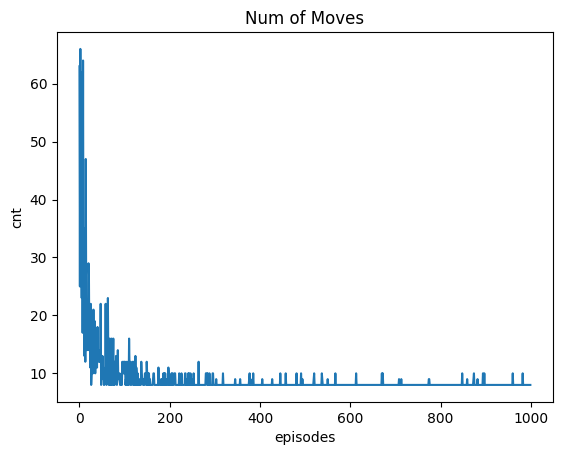

In [ ]:
plt.plot(total_moves)
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

In [ ]:
class QlearningAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.num_actions=len(action_space)

        self.step_size=0.01
        self.discount_factor=0.9
        self.epsilon =1.0
        self.epsilon_decay=0.999
        self.epsilon_min =0.01

        self.q_table=defaultdict(lambda: np.zeros(self.num_actions).tolist())

    def update_q_table(self, state, action_idx, reward, next_state, next_action_idx):
        if(self.epsilon>self.epsilon_min) :
            self.epsilon*=self.epsilon_decay

        state, next_state = str(state), str(next_state)

        #############
        q_1=self.q_table[state][action_idx]
        q_2=reward = reward + self.discount_factor*max(self.q_table[next_state])
        self.q_table[state][action_idx] += self.step_size * (q_2 - q_1)
        ############

    def get_action(self,state) :
        if np.random.rand()<self.epsilon:
            action_idx=np.random.choice(range(self.num_actions))
        else :
            state=str(state)
            q_list= self.q_table[state]
            action_idx = self.argmax(q_list)
        return action_idx

    def argmax(self,q_list) :
        max_value=np.amax(q_list) # 큐함수 중 가장 큰 인덱스 값 리턴
        max_indices = np.where(q_list==max_value)[0]
        return np.random.choice(max_indices)


In [ ]:
env=GridWorldEnvironment(start_point = (0,0), end_point=(4,4), gridworld_size=(5,5))

agent=QlearningAgent(env.action_space)

EPISODES=1000
RENDER_PROCESS = False
RENDER_END = False
total_moves = []

In [ ]:
for episode in range(EPISODES):
    state=env.reset()
    moves_cnt=0
    action_idx=agent.get_action(state) # state 에서의 최대 큐함수 값을 받음

    done=False

    while not done:
        if RENDER_PROCESS:
            env.render()

        next_state, reward, done = env.step(action_idx)

        next_action_idx = agent.get_action(next_state)

        agent.update_q_table(state, action_idx, reward, next_state, next_action_idx)

        state = next_state
        action_idx = next_action_idx

        moves_cnt+=1

    total_moves.append(moves_cnt)

    if(episode+1 ) %100 == 0 :
        print(f"[Episode]: {episode+1}/{EPISODES} __ [Num of Moves mean]:{np.mean(total_moves[episode-99:]):.1f} __ [Epsilon]: {agent.epsilon:.3f}")

    if RENDER_END:
        env.render()

[Episode]: 100/1000 __ [Num of Moves mean]:16.1 __ [Epsilon]: 0.199
[Episode]: 200/1000 __ [Num of Moves mean]:9.1 __ [Epsilon]: 0.080
[Episode]: 300/1000 __ [Num of Moves mean]:8.5 __ [Epsilon]: 0.034
[Episode]: 400/1000 __ [Num of Moves mean]:8.2 __ [Epsilon]: 0.015
[Episode]: 500/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 600/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 700/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 800/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 900/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 1000/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010


In [ ]:
env.render()

S . . . . 
X X . . . 
. X X X X 
. . . . X 
. . . . A 


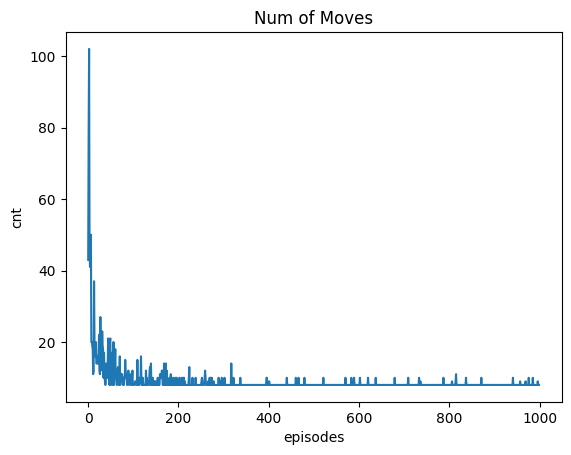

In [ ]:
plt.plot(total_moves)
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()